In [5]:
import scipy.io as sio
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import copy
from math import sin, atan

import sys
sys.path.append("../")
import data_helpers

## Import Data & Classify Data Points

In [7]:
df = data_helpers.clean_data([sio.loadmat("../tire_data/RunData_10inch_Cornering_Matlab_SI_Round6/B1654run22.mat")])

# period of oscillation is ~ 10.5 data points, remove oscillation
df["FY"] = data_helpers.moving_average(df["FY"], 10)
df["FZ"] = data_helpers.moving_average(df["FZ"], 10)

In [8]:
variable_sweeps = {"load" : {"sweep" : np.array([-250, -200, -150, -100, -50]) / 0.224809, "label" : "FZ" },
                    "camber" : {"sweep" : np.array([0, 2, 4]), "label" : "IA"},
                    "pressure" : {"sweep" : np.array([8, 10, 12, 14]) * 6.89476, "label" : "P"},
                    "velocity" : {"sweep" : np.array([15, 25, 45]) * 1.60934, "label" : "V"}}

for variable, sweep_info in variable_sweeps.items():
    nearest_val_func = lambda x: data_helpers.get_nearest_value(sweep_info["sweep"], x)
    df[variable] = df[sweep_info["label"]].apply(nearest_val_func)
    
    # counts number of points for each sweep
    sweep_info["count"] = df.groupby([variable])[variable].count()

## Choose Subset of Data for Analysis
### Most Common Sweep Variable for Each Sweep chosen

In [9]:
new_df = copy.copy(df)
for variable, info in variable_sweeps.items():
    if variable != "load":
        new_df = new_df[new_df[variable] == info["count"].idxmax()]

temp_df2 = new_df[(new_df["load"] == variable_sweeps["load"]["count"].idxmax())]

## Define Pajeka Fit Formula

In [5]:
def arctan_lat_fit(X, A, B, C, D):
    return [row["FZ"] * A * atan(B * row["SA"] + D) + C for _, row in X.iterrows()]

In [6]:
# normal force independent; removes dependency on camber and normal load
def pajeka_lat_forc_0(X, E, B, D, C):
    x = [row["FZ"] * D * sin(C * atan(B * row["SA"] - E * (B * row["SA"] - atan(B * row["SA"])))) for _, row in X.iterrows()]
    return x

In [31]:
# normal force dependent, must fit data with SAME input normal load. Camber independent
def pajeka_lat_forc_1(X, E, B, D, C):
    x = [D * sin(C * atan(B * row["SA"] - E * (B * row["SA"] - atan(B * row["SA"])))) for _, row in X.iterrows()]
    return x

In [ ]:
# camber and normal force dependent. full fit
def pajeka_lat_forc_2(X, D, B, E, C, Sh, Sv):
    theta = [(1 - E) * (x + Sh) + E / B * atan(B * (x + Sh)) for x in list(X["SA"])]
    return [D * sin(C * atan( B * x)) + Sv for x in theta]

In [ ]:
def pajeka_lat_forc_test(slip_angles, E, B, D, Sh, Sv):
    theta = [(1 - E) * (x + Sh) + E / B * atan(B * (x + Sh)) for x in list(X["SA"])]
    return [D * sin(1.3 * atan( B * x)) + Sv for x in theta]

## Compare Fit to Raw Data (ArcTangent)

In [10]:
arctan_fit_out = optimize.curve_fit(arctan_lat_fit, new_df, new_df["FY"])
arctan_fit_Fy = arctan_lat_fit(new_df, *arctan_fit_out[0])
print("Coefficients:", *arctan_fit_out[0])

Coefficients: 1.8926627799488782 0.3504025654916263 -13.959291487930637 -0.03717071497115644


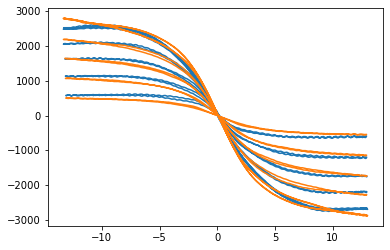

Standard Deviation from Fit (Newtons): 112.26927681018535


In [12]:
plt.plot(new_df["SA"], new_df["FY"])
plt.plot(new_df["SA"], arctan_fit_Fy)
plt.show()
print("Standard Deviation from Fit (Newtons):", data_helpers.standard_deviation(list(new_df["FY"]), arctan_fit_Fy) )

## Compare Fit to Raw Data (Pajecka 94)

In [13]:
simple_pajecka_fit = optimize.curve_fit(pajeka_lat_forc_0, new_df, new_df["FY"])
simple_pajecka_Fy = pajeka_lat_forc_0(new_df, *simple_pajecka_fit[0])
print("Coefficients:", *simple_pajecka_fit[0])

Coefficients: -0.09516445651355003 0.18205600522754753 2.471183323877657


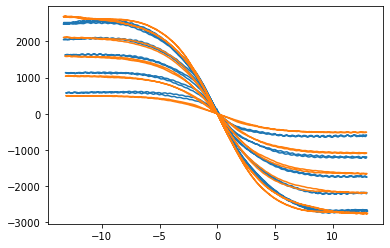

Standard Deviation from Fit (Newtons): 106.46318921295351


In [14]:
plt.plot(new_df["SA"], new_df["FY"])
plt.plot(new_df["SA"], simple_pajecka_Fy)
plt.show()
print("Standard Deviation from Fit (Newtons):", data_helpers.standard_deviation(list(new_df["FY"]), simple_pajecka_Fy) )

## Compare Fit to Raw Data (Full Pacejka)

In [45]:
output2 = optimize.curve_fit(pajeka_lat_forc_2, temp_df2, temp_df2["SA"], p0 = [2625, 0.15, 0.06, -1.5, 9.4, -79.5], maxfev= 10000)
print("Coefficients:",*output2[0])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

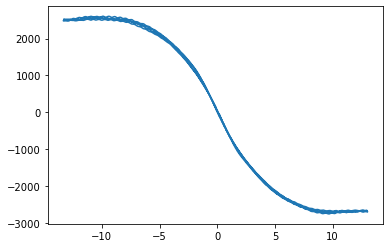

In [26]:
plt.plot(temp_df2["SA"], temp_df2["FY"])
#plt.plot(temp_df2["SA"], pajeka_lat_forc_1(temp_df2, *output2[0]))

# input_angles = [i/10 for i in range(-130, 131)]
# coefficients = [0.37849796007995107, 1.6402969387650528, 0.14421226713755966, -1000*2.452789904167964, 0, 0]
# y = pajeka_lat_forc(input_angles, *coefficients)
# plt.plot(input_angles, y)
plt.show()

In [47]:
squared_errors = (abs(new_df["FY"] - pajeka_lat_forc_94(new_df["SA"], *coefficients)))**2
print("Standard Deviation from Fit (Newtons):", (sum(squared_errors)/len(squared_errors))**0.5 )

Standard Deviation from Fit (Newtons): 798.284448941123


In [33]:
export_dict = {}
targ_p = variable_sweeps["pressure"]["count"].idxmax()
targ_v= variable_sweeps["velocity"]["count"].idxmax()

# creates dataframe with only most common pressure and velocity
filt_df = df[(df["pressure"] == targ_p) & (df["velocity"] == targ_v)]

for i_load, x_load in enumerate(variable_sweeps["load"]["sweep"]):

    load_name = "load" + str(i_load)
    export_dict.update({load_name: {"load_val" : x_load}})

    for i_camber, x_camber in enumerate(variable_sweeps["camber"]["sweep"]):

        camber_name = "camber" + str(i_camber)
        temp_dict = filt_df[(filt_df["load"] == a_load) & (filt_df["camber"] == a_camber)].to_dict("list")
        temp_dict.update({"camber_val" : x_camber})
        export_dict[load_name].update({camber_name : temp_dict})

# Export data for Matlab testing
sio.savemat('processed_data.mat', export_dict)